In [1]:
import torch
import torch.nn as nn
import pandas as pd
from torch.autograd import Variable
import torch.nn.functional as F

# 自定義資料集
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, label_path):
        self.data = pd.read_csv(data_path)
        self.labels = pd.read_csv(label_path)
    
    def __getitem__(self, index):
        # 讀取特徵和標籤
        features = torch.tensor(self.data.iloc[index].values, dtype=torch.float32, requires_grad=True)
        label = torch.tensor(self.labels.iloc[index].values, dtype=torch.long)
        return features, label
    
    def __len__(self):
        return len(self.data)
    
    def preprocess(self):
        self.data = self.data.drop(columns=['Serial No.'])
        self.labels = self.labels.drop(columns=['Serial No.'])


In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [3]:
batch_size = 1

# 創建自定義資料集
train_data_path = "triain_in.csv"
train_label_path = "train_out.csv"
test_data_path = "test_in.csv"
train_dataset = CustomDataset(train_data_path, train_label_path)
test_dataset = CustomDataset(test_data_path, train_label_path)  # 注意：測試集使用的是訓練集的標籤

train_dataset.preprocess()
test_dataset.preprocess()

# 創建資料載入器
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [4]:
train_dataset.labels.describe()

,Label
count,7494.000000
mean,4.430878
std,2.876981
min,0.000000
25%,2.000000
50%,4.000000
75%,7.000000
max,9.000000


In [5]:
input_feature_dim = 16
hidden_feature_dim = 4
hidden_layer_num = 4
learning_rate = 0.001
num_epochs = 1000

# 定義 RNN 模型
class LSTM(nn.Module):
#建立LSTM class
    def __init__(self, input_feature_dim, hidden_feature_dim, hidden_layer_num, batch_size, classes_num, batch_first=True, bidirectional=True):
        super(LSTM,self).__init__()
        self.input_feature_dim=input_feature_dim
        self.hidden_feature_dim=hidden_feature_dim
        self.hidden_layer_num=hidden_layer_num
        self.batch_size=batch_size 
				
        #初始化LSTM       
        self.lstm=nn.LSTM(input_feature_dim, hidden_feature_dim, hidden_layer_num, batch_first=True, bidirectional=True)
        #LSTM的輸出藉由單層的線性神經網路層分類~
        self.linear1=nn.Linear(hidden_feature_dim * 2,classes_num)
        
    def forward(self,input):
        input = input.view(len(input), 1, -1)
        h0 = Variable(torch.zeros(hidden_layer_num * 2, input.size(0), self.hidden_feature_dim))
        c0 = Variable(torch.zeros(hidden_layer_num * 2, input.size(0), self.hidden_feature_dim))
        output,(hn,cn) = self.lstm(input,(h0,c0))  
        output=self.linear1(output[-1])         
        return output, (hn , cn) 


# 初始化模型
model=LSTM(input_feature_dim, hidden_feature_dim, hidden_layer_num, batch_size, 16).to(device)

# 定義損失函數和優化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.ASGD(model.parameters(), lr=learning_rate)

In [6]:
from datetime import datetime

# datetime object containing current date and time
now = datetime.now()

# dd/mm/YY H:M:S
dt_string = now.strftime("%d.%m.%Y %H-%M-%S")

path = dt_string + 'loss.txt'
f = open(path, 'w')

losses = list()

# 訓練模型

for epoch in range(num_epochs):
    for features, labels in train_dataloader:
        features = features.float().to(device)
        labels = labels.squeeze(0).to(device)

        optimizer.zero_grad()
            
        # 前向傳播
        outputs, (hn,cn) = model(features) #正向傳播
        
        # 計算損失
        loss = criterion(outputs, labels)
        
        # 反向傳播和優化
        loss.backward()
        optimizer.step()

    losses.append(loss.item())
    f.write(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()} \n')
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

print('Finished Training')

print("date and time =", dt_string)

# 設定參數字典名稱
state_dict_name = dt_string + '.params'

# 儲存狀態字典
torch.save(model.state_dict(), state_dict_name)
print("Saved PyTorch Model State to " + state_dict_name)

f.close()

Epoch [1/1000], Loss: 2.4078235626220703
Epoch [2/1000], Loss: 2.3847525119781494
Epoch [3/1000], Loss: 2.4058635234832764
Epoch [4/1000], Loss: 2.328604221343994
Epoch [5/1000], Loss: 2.3296542167663574
Epoch [6/1000], Loss: 2.434053421020508
Epoch [7/1000], Loss: 2.411510467529297
Epoch [8/1000], Loss: 2.2914772033691406
Epoch [9/1000], Loss: 2.3017842769622803
Epoch [10/1000], Loss: 2.2953217029571533
Epoch [11/1000], Loss: 2.2834017276763916
Epoch [12/1000], Loss: 2.3010573387145996
Epoch [13/1000], Loss: 2.388352632522583
Epoch [14/1000], Loss: 2.2830240726470947
Epoch [15/1000], Loss: 2.2900822162628174
Epoch [16/1000], Loss: 2.3775577545166016
Epoch [17/1000], Loss: 2.352912425994873
Epoch [18/1000], Loss: 2.2909743785858154
Epoch [19/1000], Loss: 2.3581900596618652
Epoch [20/1000], Loss: 2.2771999835968018
Epoch [21/1000], Loss: 2.3645524978637695
Epoch [22/1000], Loss: 2.2639145851135254
Epoch [23/1000], Loss: 2.292219400405884
Epoch [24/1000], Loss: 2.3539092540740967
Epoch [

In [7]:
device = 'cpu'

model = model.to(device)

# 使用訓練好的模型進行預測
predicted_labels = []
for features, _ in test_dataloader:
    features = features.float().to(device)
    
    # 前向傳播
    outputs, (hn,cn) = model(features) #正向傳播
    
    # 預測標籤  
    predicted = torch.argmax(outputs, dim=1)
    predicted_labels.extend(predicted.tolist())

# 將預測結果寫入文件
submission = pd.read_csv(test_data_path)
no = submission['Serial No.']

submission = pd.DataFrame({'Serial No.':no,
                           'Label':predicted_labels})

submission.to_csv(dt_string + "_submission.csv", index=False)
print(dt_string + "_submission.csv Saved Successfully")

13.06.2023 01-38-39_submission.csv Saved Successfully


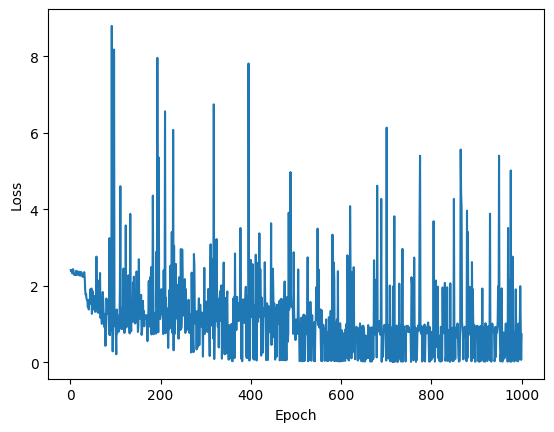

In [8]:
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs+1), losses)
# plt.ylim(0,0.01)
plt.xlabel('Epoch')  
plt.ylabel('Loss')
file_name = dt_string + '.png'
plt.savefig(file_name)
plt.show()